**The provided code defines a set of utility functions and a basic multilayer perceptron (MLP) network-building function using Haiku and JAX libraries for neural network development. Let's break down the code and provide an explanatory paragraph for each part:**

In [ ]:
!pip install jax

In [ ]:
!pip install dm-haiku

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 5.1 MB/s eta 0:00:00


In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp
import tensorflow_datasets as tfds
import tensorflow as tf
import optax
import numpy as np
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt


In [ ]:
def neural_network(x, hidden_sizes=[10, 10]):
    """Standard MLP network."""

    h = hk.Flatten()(x)
    for size in hidden_sizes:
        z = hk.Linear(size)(h)
        h = jax.nn.tanh(z)

    return hk.Linear(1)(h)


In [ ]:
@jax.jit
def sample_params(prior, rng):
    def sample_gaussian(mu, logvar):
        return jax.random.normal(rng, shape=mu.shape) * jnp.exp(logvar / 2) + mu

    sample = jax.tree_map(sample_gaussian, prior['mu'], prior['logvar'])
    return sample


In [ ]:
def predict(net, prior, batch_image, rng):
    params_rng, rng = jax.random.split(rng)
    params = sample_params(prior, params_rng)
    logits = net.apply(params, batch_image)
    stack_probs = jnp.stack(logits)
    return jnp.mean(stack_probs, axis=0), jnp.std(stack_probs, axis=0)

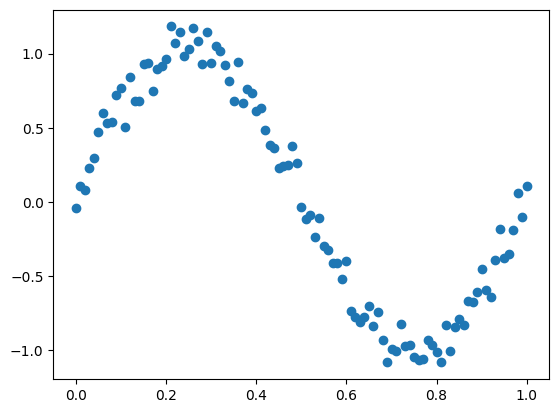

In [ ]:
# Generate evenly spaced x values
x = np.linspace(0, 1, 101).reshape(-1, 1)

# Calculate y values
y = np.sin(x * np.pi * 2) + np.random.normal(size=(101, 1), scale=0.1)


plt.scatter(x, y)

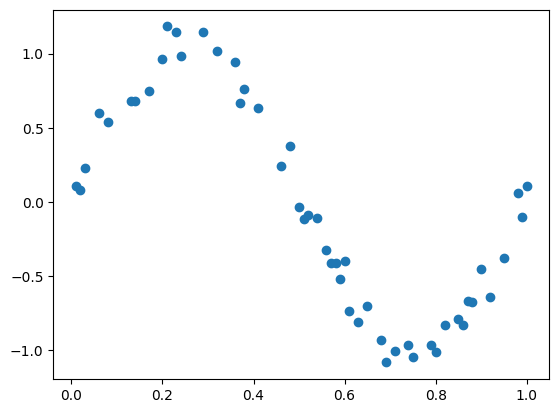

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import itertools

# Split the dataset into a training and evaluation set
X_train, X_eval, y_train, y_eval = train_test_split(x, y, test_size=0.5, random_state=42)

plt.scatter(X_train, y_train)

In [ ]:
beta = 0.0001

In [ ]:
# Define the neural network without applying random number generation
net = hk.without_apply_rng(hk.transform(neural_network, apply_rng=True ))

In [ ]:
# Initialize model
rng = hk.PRNGSequence(42)
params = net.init(next(rng), X_train)
prior = {
    'mu': params,  # Include the 'mu' key with appropriate values.
    'logvar': jax.tree_map(lambda x: -7 * jnp.ones_like(x), params),
}


In [ ]:
# Print both keys and values
print("Keys and values in 'prior' dictionary:")
for key, value in prior.items():
    print(key)

Keys and values in 'prior' dictionary:
mu
logvar


In [ ]:
def get_num_params(params):
    """Returns the number of parameters in the network."""
    num_params = 0
    for p in jax.tree_util.tree_leaves(params):
        if isinstance(p.shape, tuple):
            num_params += p.shape[0]
        else:
            num_params += jnp.prod(p.shape)

    return num_params


In [ ]:
print('Total number of parameters: ', get_num_params(prior))

Total number of parameters:  84


In [ ]:
import jax
import jax.numpy as jnp


@jax.jit
def L2_loss(logits, targets):
    """Calculate L2 loss (mean squared error) between logits and targets."""
    l2_loss = jnp.mean((logits - targets) ** 2)
    return l2_loss

@jax.jit
def kl_divergence(mu, logvar):
    """Calculate KL divergence for a Gaussian distribution."""
    kl_div = jnp.sum(jnp.exp(logvar) + mu**2 - 1 - logvar) / 2
    kl_div /= mu.shape[0]
    return kl_div

In [ ]:
def elbo(approx_posterior, X, y, rng):
    """Computes the Evidence Lower Bound."""
    params = sample_params(approx_posterior, rng) # Sample net parameters from the approximate posterior.
    # print('parameter shape', [params[i] for i in params])
    predictions = net.apply(params, X)
    # print(logits.shape, batch_label.shape)
    L2Loss = - L2_loss(predictions, y)
    # Calculate the KL divergence for each component
    kl_div_list = jax.tree_map(kl_divergence,  approx_posterior['mu'], approx_posterior['logvar'])
    kl_d = jax.tree_util.tree_reduce(jnp.add, kl_div_list)
    elbo_ = L2Loss - beta * kl_d
    return elbo_, L2Loss, kl_d

def loss(params, X, y, rng):
    """Computes the Evidence Lower Bound loss."""
    return -elbo(params, X, y, rng)[0]

@jax.jit
def update(params, opt_state, X, y, rng):
    grads = jax.grad(loss)(params, X, y, rng)
    updates, opt_state = opt.update(grads, opt_state)
    posterior = optax.apply_updates(params, updates)  # Apply the updates to the parameters.
    return posterior, opt_state


In [ ]:
elbo_losses_arr = []
accuracy_arr = []
log_likelihood_arr = []
kl_divergence_arr = []

In [ ]:
"""Calculates Loss, accuracy on given dataset"""
def evaluate_performance(X_eval, y_eval, params, rng, it):
  logits = predict(net, params, X_eval, next(rng))[0]
  elbo_, L2Loss, kl_divergence = elbo(params, X_eval, y_eval, next(rng))
  mean_aprx_evidence = jnp.exp(elbo_ / 10)

  # Append the values to the arrays
  elbo_losses_arr.append(float(elbo_))
  log_likelihood_arr.append(float(L2Loss))
  kl_divergence_arr.append(float(kl_divergence))

  print(
    f'iteration: {it}',
    f'elbo: {float(elbo_):.5f}',
    f'L2 Loss: {float(L2Loss):.5f}',
    f'kl_divergence: {float(kl_divergence):.5f}',
    f'mean_approximate_evidence: {float(mean_aprx_evidence):.5f}'
  )

In [ ]:
# Define and initialize optimizer.
opt = optax.adam(1e-2)
opt_state = opt.init(prior)

In [ ]:
n_steps = 30000

In [ ]:
step = 0
while True:
  # Do SGD on a batch of training examples.
  if step % 100 == 0:
    evaluate_performance(X_eval, y_eval, prior, rng, step)
  if step == n_steps:
    break
  step = step + 1
  kwargs = dict(params=prior,
            opt_state=opt_state,
            X = X_train,
                y = y_train)

  kwargs['rng'] = next(rng)
  prior, opt_state = update(**kwargs)


iteration: 0 elbo: -0.79922 L2 Loss: -0.79162 kl_divergence: 76.00484 mean_approximate_evidence: 0.92319
iteration: 100 elbo: -0.19706 L2 Loss: -0.18954 kl_divergence: 75.26365 mean_approximate_evidence: 0.98049
iteration: 200 elbo: -0.10426 L2 Loss: -0.09663 kl_divergence: 76.25665 mean_approximate_evidence: 0.98963
iteration: 300 elbo: -0.03910 L2 Loss: -0.03119 kl_divergence: 79.11194 mean_approximate_evidence: 0.99610
iteration: 400 elbo: -0.03204 L2 Loss: -0.02398 kl_divergence: 80.51813 mean_approximate_evidence: 0.99680
iteration: 500 elbo: -0.03226 L2 Loss: -0.02405 kl_divergence: 82.08308 mean_approximate_evidence: 0.99678
iteration: 600 elbo: -0.02173 L2 Loss: -0.01339 kl_divergence: 83.39732 mean_approximate_evidence: 0.99783
iteration: 700 elbo: -0.02716 L2 Loss: -0.01879 kl_divergence: 83.72089 mean_approximate_evidence: 0.99729
iteration: 800 elbo: -0.02933 L2 Loss: -0.02094 kl_divergence: 83.90144 mean_approximate_evidence: 0.99707
iteration: 900 elbo: -0.02487 L2 Loss: 

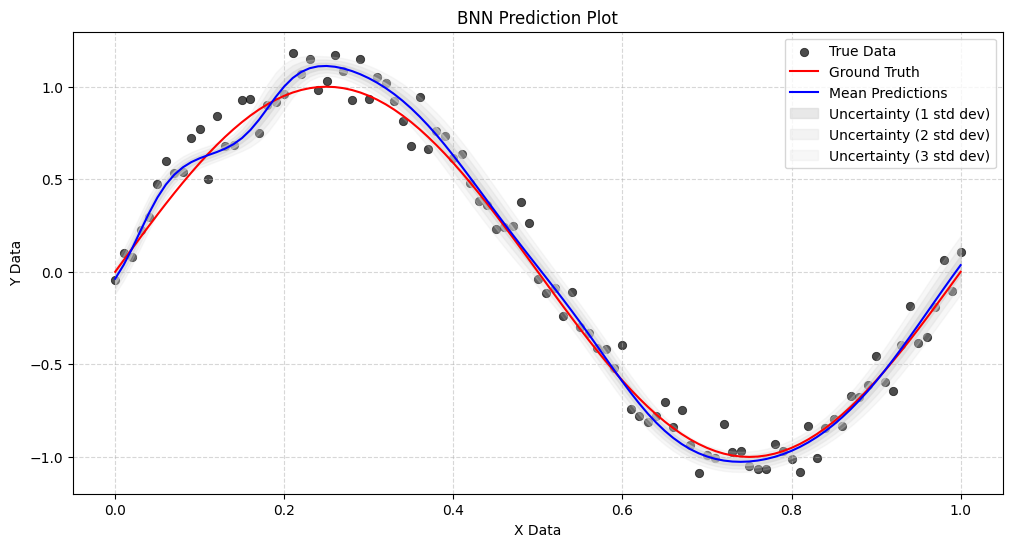

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Number of samples to draw from the posterior
num_samples = 100

# Lists to store predicted values and uncertainties
predicted_values = []

for _ in range(num_samples):
    sampled_params = sample_params(prior, next(rng))
    sampled_logits = net.apply(sampled_params, x)
    predicted_values.append(sampled_logits)

# Calculate the mean and standard deviation of the predictions
mean_predictions = jnp.mean(jnp.stack(predicted_values), axis=0)
std_predictions = jnp.std(jnp.stack(predicted_values), axis=0)

# Sort the data for cleaner plotting
sorted_indices = np.argsort(x.flatten())
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]

# Create a figure and axis
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the true data
ax.scatter(x_sorted, y_sorted, label='True Data', marker="o", alpha=0.7, lw=0.6, color='black')

# Plot the actual function
ax.plot(x_sorted, np.sin(2 * np.pi * x_sorted), label='Ground Truth', color='red')

# Plot the mean predictions
ax.plot(x_sorted, mean_predictions_sorted, label='Mean Predictions', color='blue')

# Fill between one standard deviation of the predictions (1 std)
for i in range(1, 4):
    std_plt = plt.gca().fill_between(
        x_sorted.squeeze(), (mean_predictions_sorted - i * std_predictions_sorted).squeeze(), (mean_predictions_sorted + i * std_predictions_sorted).squeeze(),
        color='lightgray', alpha=0.5 / i, label=f'Uncertainty ({i} std dev)')

# Set axis labels and title
ax.set_xlabel('X Data')
ax.set_ylabel('Y Data')
ax.set_title('BNN Prediction Plot')

# Add a legend and grid
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

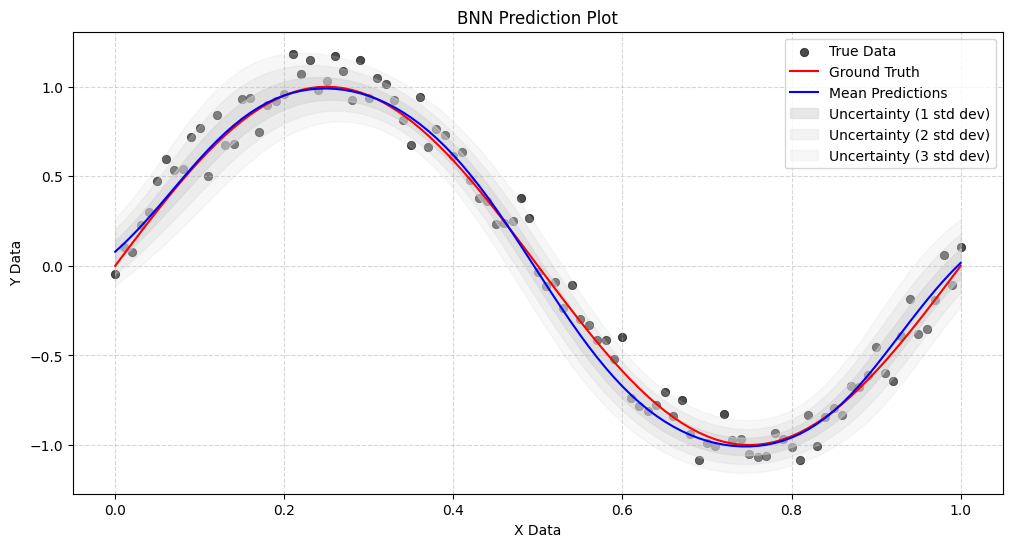

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Number of samples to draw from the posterior
num_samples = 100

# Lists to store predicted values and uncertainties
predicted_values = []

for _ in range(num_samples):
    sampled_params = sample_params(prior, next(rng))
    sampled_logits = net.apply(sampled_params, x)
    predicted_values.append(sampled_logits)

# Calculate the mean and standard deviation of the predictions
mean_predictions = jnp.mean(jnp.stack(predicted_values), axis=0)
std_predictions = jnp.std(jnp.stack(predicted_values), axis=0)

# Sort the data for cleaner plotting
sorted_indices = np.argsort(x.flatten())
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]

# Create a figure and axis
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the true data
ax.scatter(x_sorted, y_sorted, label='True Data', marker="o", alpha=0.7, lw=0.6, color='black')

# Plot the actual function
ax.plot(x_sorted, np.sin(2 * np.pi * x_sorted), label='Ground Truth', color='red')

# Plot the mean predictions
ax.plot(x_sorted, mean_predictions_sorted, label='Mean Predictions', color='blue')

# Fill between one standard deviation of the predictions (1 std)
for i in range(1, 4):
    std_plt = plt.gca().fill_between(
        x_sorted.squeeze(), (mean_predictions_sorted - i * std_predictions_sorted).squeeze(), (mean_predictions_sorted + i * std_predictions_sorted).squeeze(),
        color='lightgray', alpha=0.5 / i, label=f'Uncertainty ({i} std dev)')

# Set axis labels and title
ax.set_xlabel('X Data')
ax.set_ylabel('Y Data')
ax.set_title('BNN Prediction Plot')

# Add a legend and grid
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

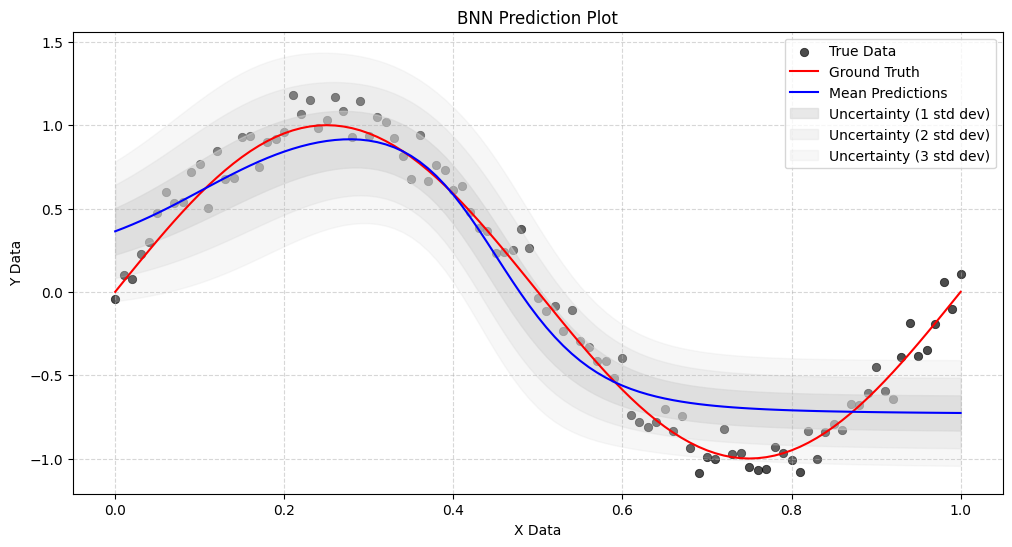

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Number of samples to draw from the posterior
num_samples = 100

# Lists to store predicted values and uncertainties
predicted_values = []

for _ in range(num_samples):
    sampled_params = sample_params(prior, next(rng))
    sampled_logits = net.apply(sampled_params, x)
    predicted_values.append(sampled_logits)

# Calculate the mean and standard deviation of the predictions
mean_predictions = jnp.mean(jnp.stack(predicted_values), axis=0)
std_predictions = jnp.std(jnp.stack(predicted_values), axis=0)

# Sort the data for cleaner plotting
sorted_indices = np.argsort(x.flatten())
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]

# Create a figure and axis
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the true data
ax.scatter(x_sorted, y_sorted, label='True Data', marker="o", alpha=0.7, lw=0.6, color='black')

# Plot the actual function
ax.plot(x_sorted, np.sin(2 * np.pi * x_sorted), label='Ground Truth', color='red')

# Plot the mean predictions
ax.plot(x_sorted, mean_predictions_sorted, label='Mean Predictions', color='blue')

# Fill between one standard deviation of the predictions (1 std)
for i in range(1, 4):
    std_plt = plt.gca().fill_between(
        x_sorted.squeeze(), (mean_predictions_sorted - i * std_predictions_sorted).squeeze(), (mean_predictions_sorted + i * std_predictions_sorted).squeeze(),
        color='lightgray', alpha=0.5 / i, label=f'Uncertainty ({i} std dev)')

# Set axis labels and title
ax.set_xlabel('X Data')
ax.set_ylabel('Y Data')
ax.set_title('BNN Prediction Plot')

# Add a legend and grid
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

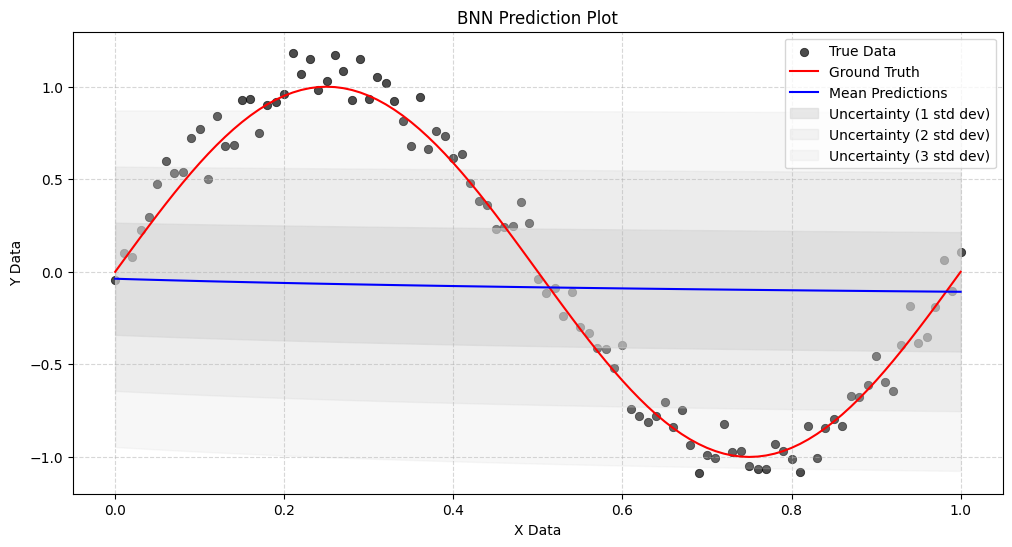

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Number of samples to draw from the posterior
num_samples = 100

# Lists to store predicted values and uncertainties
predicted_values = []

for _ in range(num_samples):
    sampled_params = sample_params(prior, next(rng))
    sampled_logits = net.apply(sampled_params, x)
    predicted_values.append(sampled_logits)

# Calculate the mean and standard deviation of the predictions
mean_predictions = jnp.mean(jnp.stack(predicted_values), axis=0)
std_predictions = jnp.std(jnp.stack(predicted_values), axis=0)

# Sort the data for cleaner plotting
sorted_indices = np.argsort(x.flatten())
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]

# Create a figure and axis
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the true data
ax.scatter(x_sorted, y_sorted, label='True Data', marker="o", alpha=0.7, lw=0.6, color='black')

# Plot the actual function
ax.plot(x_sorted, np.sin(2 * np.pi * x_sorted), label='Ground Truth', color='red')

# Plot the mean predictions
ax.plot(x_sorted, mean_predictions_sorted, label='Mean Predictions', color='blue')

# Fill between one standard deviation of the predictions (1 std)
for i in range(1, 4):
    std_plt = plt.gca().fill_between(
        x_sorted.squeeze(), (mean_predictions_sorted - i * std_predictions_sorted).squeeze(), (mean_predictions_sorted + i * std_predictions_sorted).squeeze(),
        color='lightgray', alpha=0.5 / i, label=f'Uncertainty ({i} std dev)')

# Set axis labels and title
ax.set_xlabel('X Data')
ax.set_ylabel('Y Data')
ax.set_title('BNN Prediction Plot')

# Add a legend and grid
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

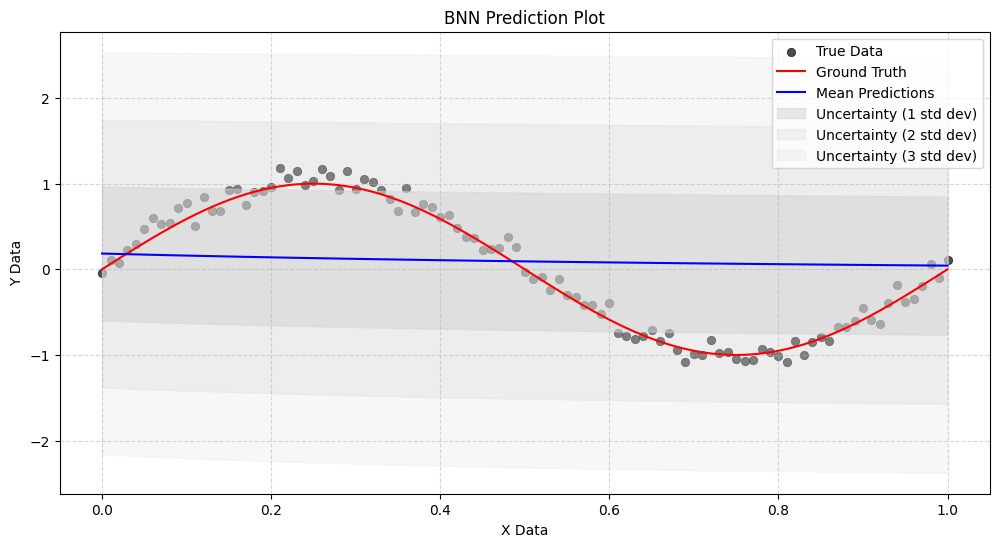

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Number of samples to draw from the posterior
num_samples = 100

# Lists to store predicted values and uncertainties
predicted_values = []

for _ in range(num_samples):
    sampled_params = sample_params(prior, next(rng))
    sampled_logits = net.apply(sampled_params, x)
    predicted_values.append(sampled_logits)

# Calculate the mean and standard deviation of the predictions
mean_predictions = jnp.mean(jnp.stack(predicted_values), axis=0)
std_predictions = jnp.std(jnp.stack(predicted_values), axis=0)

# Sort the data for cleaner plotting
sorted_indices = np.argsort(x.flatten())
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]
mean_predictions_sorted = mean_predictions[sorted_indices]
std_predictions_sorted = std_predictions[sorted_indices]

# Create a figure and axis
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Plot the true data
ax.scatter(x_sorted, y_sorted, label='True Data', marker="o", alpha=0.7, lw=0.6, color='black')

# Plot the actual function
ax.plot(x_sorted, np.sin(2 * np.pi * x_sorted), label='Ground Truth', color='red')

# Plot the mean predictions
ax.plot(x_sorted, mean_predictions_sorted, label='Mean Predictions', color='blue')

# Fill between one standard deviation of the predictions (1 std)
for i in range(1, 4):
    std_plt = plt.gca().fill_between(
        x_sorted.squeeze(), (mean_predictions_sorted - i * std_predictions_sorted).squeeze(), (mean_predictions_sorted + i * std_predictions_sorted).squeeze(),
        color='lightgray', alpha=0.5 / i, label=f'Uncertainty ({i} std dev)')

# Set axis labels and title
ax.set_xlabel('X Data')
ax.set_ylabel('Y Data')
ax.set_title('BNN Prediction Plot')

# Add a legend and grid
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()